In [1]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 50)
import numpy as np
import matplotlib.pyplot as plt
import precision_recall_cutoff as prc
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

## Defining the bucket
s3 = boto3.resource('s3')
bucket_name = 'data-448-bucket-callaghan'
bucket = s3.Bucket(bucket_name)

## Defining the csv file
file_key = 'turnover.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

## 1. Using the pandas library to read the csv data file and create a data-frame called turnover

turnover = pd.read_csv(file_content_stream)

turnover.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [2]:
## 2. Changing sales and salary from labels to dummy variables

## Sales
turnover = pd.concat([turnover.drop(columns = ['sales']), pd.get_dummies(turnover['sales'])], axis = 1)

## Salary
turnover = pd.concat([turnover.drop(columns = ['salary']), pd.get_dummies(turnover['salary'])], axis = 1)

turnover.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical,high,low,medium
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [3]:
## 3. Engineering the interactions/features from In-Class assignment 9 (the ones from the decision tree)

turnover['Interaction_1'] = np.where((turnover['satisfaction_level'] <= 0.465) & (turnover['number_project'] <= 2.5) & 
                                     (turnover['last_evaluation'] <= 0.575), 1, 0)

turnover['Interaction_2'] = np.where((turnover['satisfaction_level'] <= 0.465) & (turnover['number_project'] > 2.5) & 
                                     (turnover['satisfaction_level'] <= 0.115), 1, 0)

turnover['Interaction_3'] = np.where((turnover['satisfaction_level'] > 0.465) & (turnover['time_spend_company'] <= 4.5) & 
                                     (turnover['average_montly_hours'] <= 290.5), 1, 0)

In [4]:
## 4. Using satisfaction level, last evaluation, number project, average montly hours, time spend company, Work accident, 
## promotion last 5years, sales (dummy variables), and salary (dummy variables) and interactions/features as the input 
## variables and left as the target variable to split the data into two data-frames 

## Defining the input and target variables
X = turnover.drop(columns = ['left'])
Y = turnover['left']

## Splitting the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

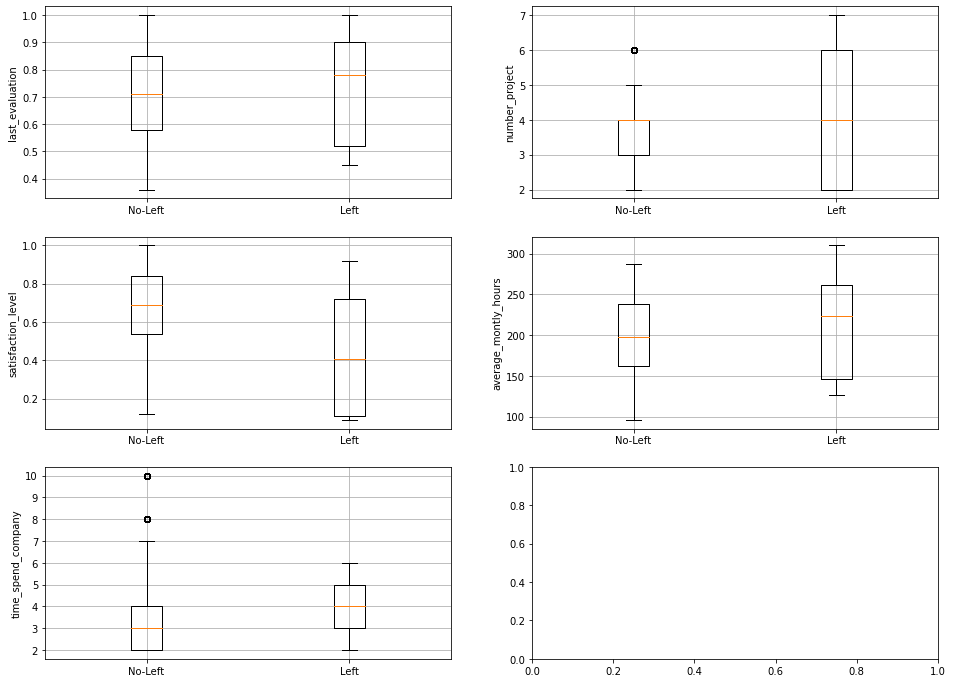

In [5]:
## 5. Using the train data-frame to: 
## (i) Visualize and inspect the relationship between each of the predictor variables and left
## (ii) Subjectively identify the top 7 features that can help to predict left based on results

turnover_train = pd.concat([X_train, Y_train], axis = 1)

## Creating a new figure
fig, axes = plt.subplots(3, 2, figsize = (16, 12))

## Subsetting the data
left = turnover_train[turnover_train['left'] == 1]
no_left = turnover_train[turnover_train['left'] == 0]

axes[0, 0].boxplot([no_left['last_evaluation'], left['last_evaluation']], labels = ['No-Left', 'Left'])
axes[0, 0].set_ylabel('last_evaluation')
axes[0, 0].grid()

axes[0, 1].boxplot([no_left['number_project'], left['number_project']], labels = ['No-Left', 'Left'])
axes[0, 1].set_ylabel('number_project')
axes[0, 1].grid()

axes[1, 0].boxplot([no_left['satisfaction_level'], left['satisfaction_level']], labels = ['No-Left', 'Left'])
axes[1, 0].set_ylabel('satisfaction_level')
axes[1, 0].grid()

axes[1, 1].boxplot([no_left['average_montly_hours'], left['average_montly_hours']], labels = ['No-Left', 'Left'])
axes[1, 1].set_ylabel('average_montly_hours')
axes[1, 1].grid()

axes[2, 0].boxplot([no_left['time_spend_company'], left['time_spend_company']], labels = ['No-Left', 'Left'])
axes[2, 0].set_ylabel('time_spend_company')
axes[2, 0].grid()

In [6]:
pd.crosstab(turnover_train['Work_accident'], turnover_train['left'], normalize = 'index')

left,0,1
Work_accident,,
0,0.734759,0.265241
1,0.924737,0.075263


In [7]:
pd.crosstab(turnover_train['promotion_last_5years'], turnover_train['left'], normalize = 'index')

left,0,1
promotion_last_5years,,
0,0.758069,0.241931
1,0.937500,0.062500


In [8]:
pd.crosstab(turnover_train['IT'], turnover_train['left'], normalize = 'index')

left,0,1
IT,,
0,0.761195,0.238805
1,0.769697,0.230303


In [9]:
pd.crosstab(turnover_train['RandD'], turnover_train['left'], normalize = 'index')

left,0,1
RandD,,
0,0.757013,0.242987
1,0.850318,0.149682


In [10]:
pd.crosstab(turnover_train['accounting'], turnover_train['left'], normalize = 'index')

left,0,1
accounting,,
0,0.763533,0.236467
1,0.731826,0.268174


In [11]:
pd.crosstab(turnover_train['hr'], turnover_train['left'], normalize = 'index')

left,0,1
hr,,
0,0.764685,0.235315
1,0.708263,0.291737


In [12]:
pd.crosstab(turnover_train['management'], turnover_train['left'], normalize = 'index')

left,0,1
management,,
0,0.757650,0.242350
1,0.860606,0.139394


In [13]:
pd.crosstab(turnover_train['marketing'], turnover_train['left'], normalize = 'index')

left,0,1
marketing,,
0,0.761989,0.238011
1,0.760402,0.239598


In [14]:
pd.crosstab(turnover_train['product_mng'], turnover_train['left'], normalize = 'index')

left,0,1
product_mng,,
0,0.761226,0.238774
1,0.772599,0.227401


In [15]:
pd.crosstab(turnover_train['sales'], turnover_train['left'], normalize = 'index')

left,0,1
sales,,
0,0.763634,0.236366
1,0.757366,0.242634


In [16]:
pd.crosstab(turnover_train['support'], turnover_train['left'], normalize = 'index')

left,0,1
support,,
0,0.763871,0.236129
1,0.750562,0.249438


In [17]:
pd.crosstab(turnover_train['technical'], turnover_train['left'], normalize = 'index')

left,0,1
technical,,
0,0.765250,0.234750
1,0.746648,0.253352


In [18]:
pd.crosstab(turnover_train['high'], turnover_train['left'], normalize = 'index')

left,0,1
high,,
0,0.746320,0.253680
1,0.934542,0.065458


In [19]:
pd.crosstab(turnover_train['low'], turnover_train['left'], normalize = 'index')

left,0,1
low,,
0,0.818093,0.181907
1,0.702452,0.297548


In [20]:
pd.crosstab(turnover_train['medium'], turnover_train['left'], normalize = 'index')

left,0,1
medium,,
0,0.736225,0.263775
1,0.795749,0.204251
